In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/Hyperspectral Image Datasets/Datasets/

/content/drive/MyDrive/Colab Notebooks/Hyperspectral Image Datasets/Data


# Import Libraries

In [ ]:
!pip install earthpy

In [ ]:
!pip install tensorflow_addons

In [ ]:
!pip install spectral

In [8]:
import sys
# Append the directory to your python path using sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Project_Path')
# Import the module
import SWIN_Transformer_Model

In [10]:
import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, MaxPooling2D, Dropout, Flatten, Conv2D, Conv3D, LeakyReLU, Reshape
from keras.models import Sequential
from keras.utils import to_categorical
from keras import layers
from keras.models import Model
from tensorflow.python.keras.utils import np_utils
import tensorflow_addons as tfa


from tqdm import tqdm
from numpy.random import seed
from time import time

from SWIN_Transformer_Model import PatchMerging, PatchExtract, PatchEmbedding, SwinTransformer
from operator import truediv
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA

import os

seed(11)

# Load Data

In [11]:
################## X data (145, 145, 200)   Hyperspectral satellite   (145*145, 200)
data = loadmat('IP/Indian_pines_corrected.mat')['indian_pines_corrected']


###################### Y data (labels)
gt = loadmat('IP/Indian_pines_gt.mat')['indian_pines_gt']

print(f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

Data Shape: (145, 145)
Number of Bands: 200


In [ ]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))

df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = gt.ravel()

In [ ]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [ ]:
df

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,2561,3987,4011,4023,4201,4377,4418,4248,4180,3838,...,1013,1012,1018,1015,1011,1001,1000,1009,1008,0
21021,2726,4104,4024,3880,4210,4377,4413,4174,4229,3900,...,1012,1014,1012,1024,998,1010,1006,1000,1000,0
21022,3153,3864,4282,3889,4310,4372,4375,4208,4096,3878,...,1016,1015,1016,1021,1008,1019,1003,1008,1000,0
21023,3155,4104,4106,4027,4139,4318,4413,4174,4140,3933,...,1005,1011,1008,1012,1014,1007,1011,1005,1003,0


In [ ]:
df['class'].unique()

array([ 3,  0, 15, 11, 12,  5, 10, 14, 16,  2,  4,  8,  6,  9,  1,  7, 13],
      dtype=uint8)

# Data Visualization

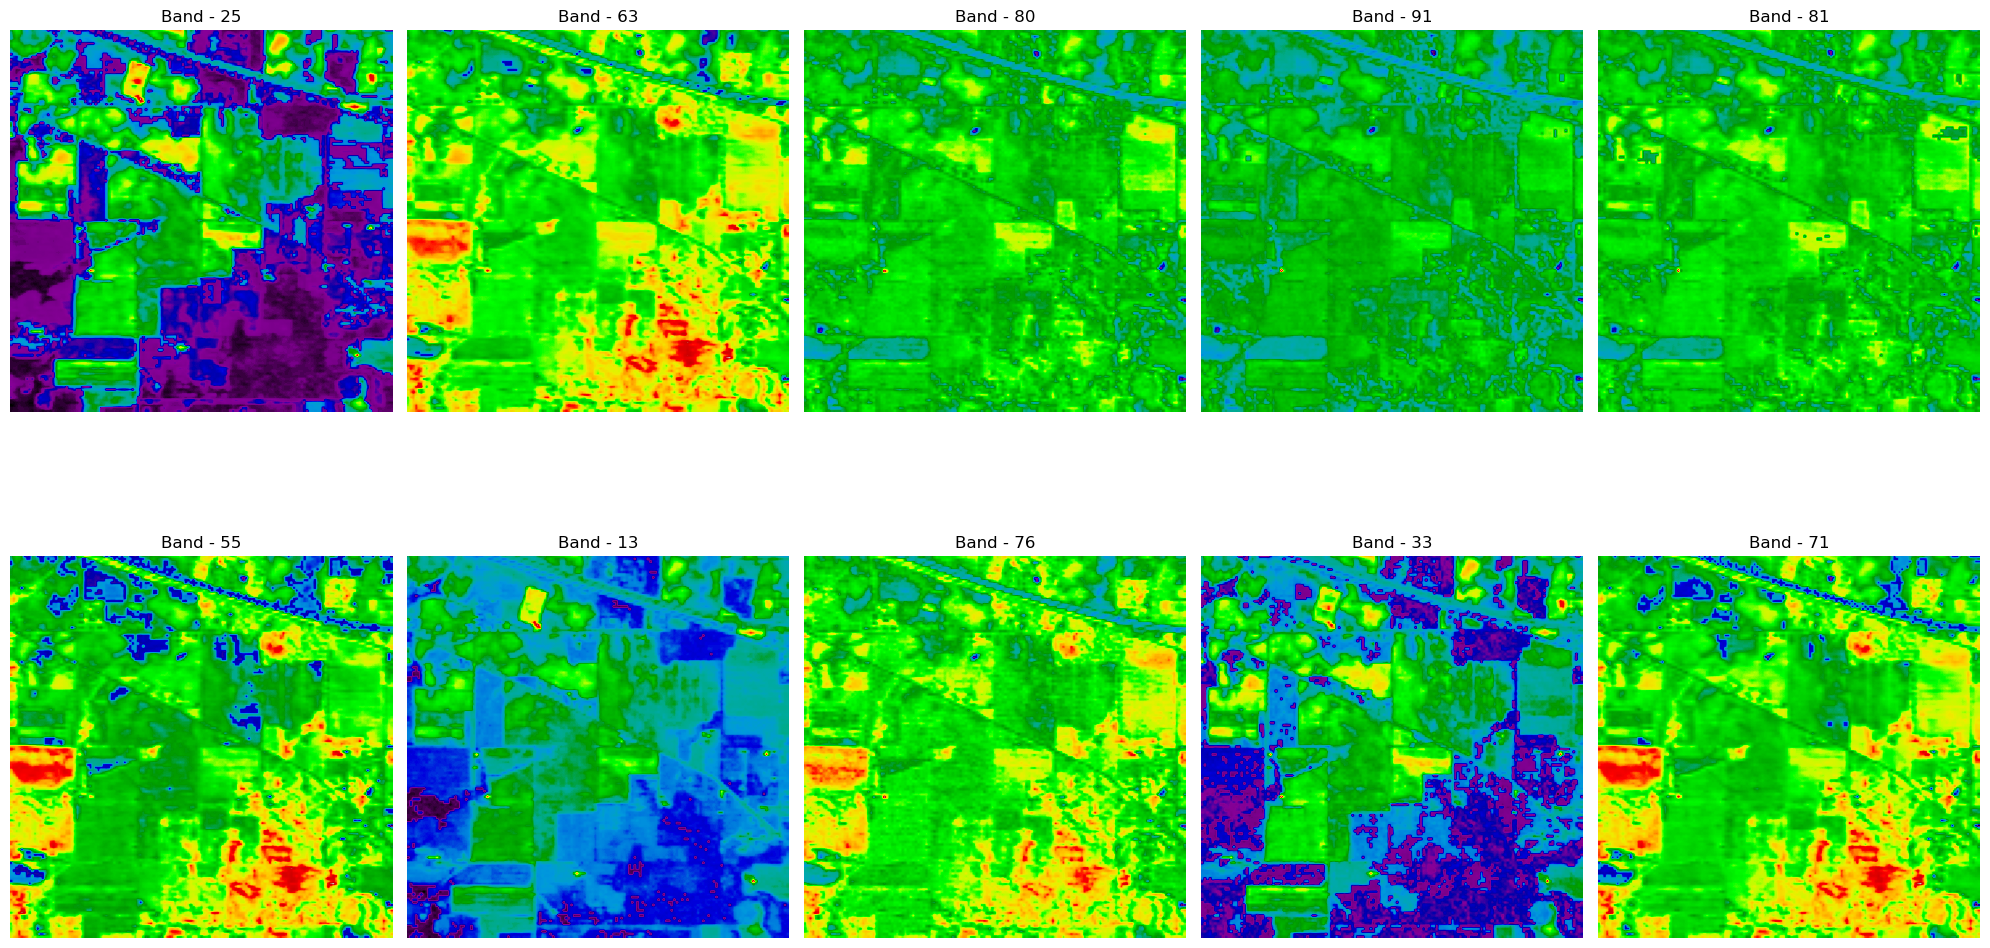

In [ ]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()
plt.show()


# RGB Composite Image

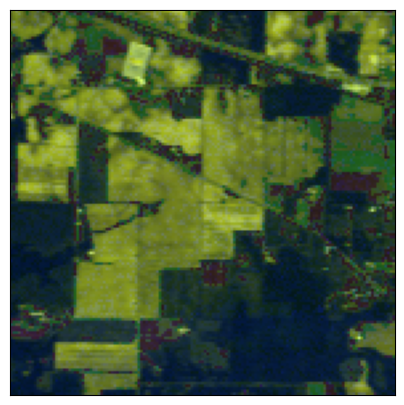

In [ ]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (29, 23, 0), figsize=(5, 5))

plt.show()

# GroundTruth Visualizaation

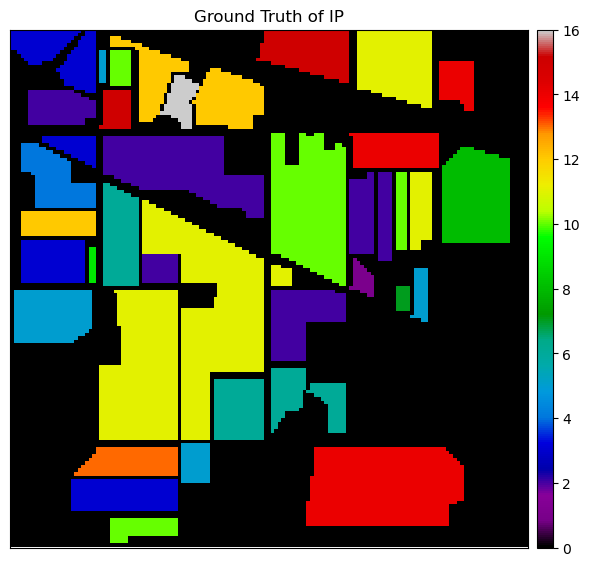

In [ ]:
ep.plot_bands(gt, cmap='nipy_spectral', title='Ground Truth of IP', figsize=(7, 9))
plt.show()

# Data Preparation

In [12]:
## GLOBAL VARIABLES

# Proportion of the sample used for testing
test_ratio = 0.7
# Proportion of the sample used for Validation
val_ratio = 0.1
# Size of the extracted patch around each pixel
patch1_size = 25
# Number of principal components obtained by dimensionality reduction using PCA (original data: 30)
pca_components = 30
# classes
num_classes = 16
dataset='IP'

In [13]:
# Apply PCA transform to hyperspectral data X
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

In [14]:
# When extracting the patch around a single pixel, the edge pixels cannot be taken, so a padding operation is applied to this part of the pixel (margin original is 2)
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [15]:
# Extract the patch around each pixel and create it in a format that matches the keras processing (originally windowSize=5)
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    # for X to padding
    margin = int((windowSize ) / 2)  # hybirdcnn是（（windowsize-1）/2）
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [16]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [17]:
print('Hyperspectral data shape: ', data.shape)
print('Label shape: ', gt.shape)

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)


In [18]:
print('\n... ... PCA tranformation ... ...')
X = applyPCA(data, numComponents=pca_components)
print('Data shape after PCA: ', X.shape)


... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)


In [19]:
#X, Y = createImageCubes(data, gt, windowSize=windowSize, removeZeroLabels = True)
#X.shape, Y.shape

print('\n... ... create data cubes ... ...')
X, Y = createImageCubes(X, gt, windowSize=patch1_size)
print('Data cube X shape: ', X.shape)
print('Data cube y shape: ', Y.shape)


... ... create data cubes ... ...
Data cube X shape:  (10249, 25, 25, 30)
Data cube y shape:  (10249,)


In [20]:
# Reshape The X because we used 3D
#(n, W, H, B)
#(n, W, H, B, 1)
X = X.reshape((X.shape[0],patch1_size,patch1_size,30,1))
X.shape

(10249, 25, 25, 30, 1)

# Split Data

In [21]:
print('\n... ... create train & val & test data ... ...')
X_train, X_test, y_train, y_test = splitTrainTestSet(X, Y, test_ratio)
X_train, X_val, y_train, y_val = splitTrainTestSet(X_train, y_train, val_ratio)

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('X_test  shape: ', X_test.shape)
print('y_train shape: ',y_train.shape)
print('y_val shape: ',y_val.shape)
print('y_test shape:' , y_test.shape)


... ... create train & val & test data ... ...
X_train shape:  (2766, 25, 25, 30, 1)
X_val shape:  (308, 25, 25, 30, 1)
X_test  shape:  (7175, 25, 25, 30, 1)
y_train shape:  (2766,)
y_val shape:  (308,)
y_test shape: (7175,)


In [22]:
# Change the shape of y_train, y_val and  to match keras
y_train=np_utils.to_categorical(y_train)
y_val=np_utils.to_categorical(y_val)
y_test=np_utils.to_categorical(y_test)

print('y_train shape: ',y_train.shape)
print('y_val shape: ',y_val.shape)
print('y_test shape:' , y_test.shape)

y_train shape:  (2766, 16)
y_val shape:  (308, 16)
y_test shape: (7175, 16)


# Parameters and Functions

In [23]:
#input_shape = (25, 25, 30) #need to follow loading.shape and afterPCA ---> ip_shape
input_shape = (25, 25, 30, 1)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate (origin0.03)
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension (origin64)
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 25  # Initial image size (origin32) （afterPCA25）（afterCNN module 17）

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
#num_epochs = 10
num_epochs = 1
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

# Build Model

In [24]:
imIn = Input(shape=input_shape)
imIn

<KerasTensor: shape=(None, 25, 25, 30, 1) dtype=float32 (created by layer 'input_1')>

In [28]:
# CNN Model
## 3D Convolutional Layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(imIn)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
print("---------------------------")
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)

#2DCNN
conv_layer4 =Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
print(conv_layer4.shape)
print("---------------------------")

# SWIN Transformer Layers
x = layers.RandomCrop(image_dimension, image_dimension)(conv_layer4)
print('random crop:',x.shape)
x = layers.RandomFlip("horizontal")(x)
print('random flip:',x.shape)
x = PatchExtract(patch_size)(x)
print('patch extract:',x.shape)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
print('patch embedding:',x.shape)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
print('swin1:',x.shape)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
print('swin2:',x.shape)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
print('patchmerging:',x.shape)
x = layers.GlobalAveragePooling1D()(x)
print('global average pooling:',x.shape)
output = layers.Dense(num_classes, activation="softmax")(x)
print('out:',x.shape)

(None, 19, 19, 18, 32)
---------------------------
(None, 17, 17, 64)
---------------------------
random crop: (None, 25, 25, 64)
random flip: (None, 25, 25, 64)
patch extract: (None, 144, 256)
patch embedding: (None, 144, 64)
swin1: (None, 144, 64)
swin2: (None, 144, 64)
patchmerging: (None, 36, 128)
global average pooling: (None, 128)
out: (None, 128)


In [29]:
model = Model(inputs=[imIn], outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_7 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_8 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape_2 (Reshape)         (None, 19, 19, 576)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 64)        331840    
                                                                 
 random_crop_2 (RandomCrop)  (None, 25, 25, 64)        0   

## Train Model

In [30]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

In [31]:
start = time()

history = model.fit(
    X_train, #The display is modified: the original indicates x_train, y_train
    y_train, #
    batch_size=batch_size,
    epochs=100,
    validation_data = (X_val, y_val),
)

end = time()
print("\n Training Time:", (end-start))

# Save Training Hostry to CSV
history_data = pd.DataFrame(history.history)
history_data_csv_file = '/content/drive/MyDrive/Colab Notebooks/Save_Files/IP/IP_history.csv'
with open(history_data_csv_file, mode='w') as f:
    history_data.to_csv(f)

Epoch 1/100
22/22 [==============================] - 13s 148ms/step - loss: 3.0341 - accuracy: 0.2093 - val_loss: 2.2888 - val_accuracy: 0.2792
Epoch 2/100
22/22 [==============================] - 1s 35ms/step - loss: 1.7092 - accuracy: 0.5597 - val_loss: 1.1830 - val_accuracy: 0.8247
Epoch 3/100
22/22 [==============================] - 1s 35ms/step - loss: 1.0846 - accuracy: 0.8485 - val_loss: 0.9179 - val_accuracy: 0.9091
Epoch 4/100
22/22 [==============================] - 1s 35ms/step - loss: 0.8864 - accuracy: 0.9179 - val_loss: 0.8174 - val_accuracy: 0.9448
Epoch 5/100
22/22 [==============================] - 1s 35ms/step - loss: 0.8099 - accuracy: 0.9472 - val_loss: 0.7833 - val_accuracy: 0.9545
Epoch 6/100
22/22 [==============================] - 1s 35ms/step - loss: 0.7544 - accuracy: 0.9635 - val_loss: 0.7472 - val_accuracy: 0.9838
Epoch 7/100
22/22 [==============================] - 1s 35ms/step - loss: 0.7225 - accuracy: 0.9740 - val_loss: 0.7141 - val_accuracy: 0.9805
Epoc

## Result

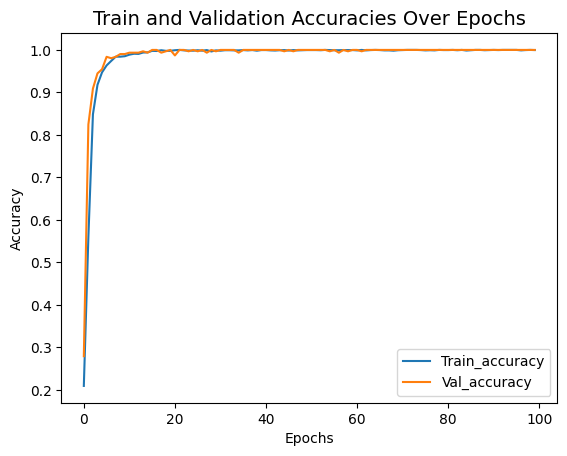

In [32]:
plt.plot(history.history["accuracy"], label="Train_accuracy")
plt.plot(history.history["val_accuracy"], label="Val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracies Over Epochs", fontsize=14)
plt.legend()
#plt.grid()
plt.show()

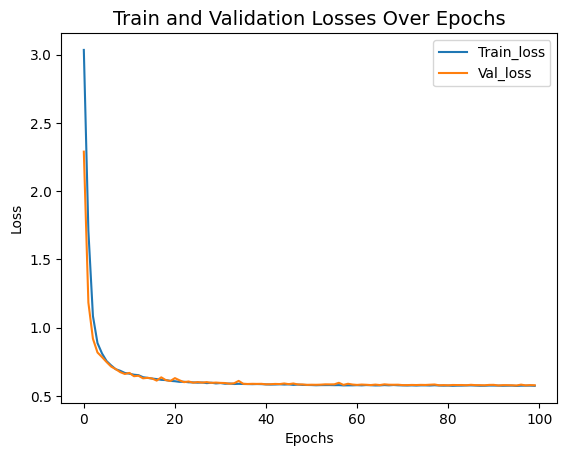

In [33]:
plt.plot(history.history["loss"], label="Train_loss")
plt.plot(history.history["val_loss"], label="Val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
#plt.grid()
plt.show()

In [34]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

225/225 [==============================] - 2s 9ms/step - loss: 0.5827 - accuracy: 0.9990
Test loss: 0.58
Test accuracy: 99.9%


In [35]:
Y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(y_test, axis=1), y_pred_test)
print(classification)

225/225 [==============================] - 3s 8ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00       581
           3       1.00      1.00      1.00       166
           4       1.00      0.99      1.00       338
           5       1.00      1.00      1.00       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00       680
          10       1.00      1.00      1.00      1719
          11       1.00      1.00      1.00       415
          12       0.99      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       1.00      1.00      1.00       270
          15       0.98      0.98      0.98        65

    accuracy             

## Classification Map

In [36]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [37]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [38]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(X_test,y_test,dataset)
classification = str(classification)
confusion = str(confusion)
print(classification)
file_name = "/content/drive/MyDrive/Colab Notebooks/Save_Files/IP/IP_classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 2s 8ms/step - loss: 0.5823 - accuracy: 0.9992
                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        32
                 Corn-notill       1.00      1.00      1.00      1000
                Corn-mintill       1.00      1.00      1.00       581
                        Corn       1.00      1.00      1.00       166
               Grass-pasture       1.00      1.00      1.00       338
                 Grass-trees       1.00      1.00      1.00       511
         Grass-pasture-mowed       0.95      1.00      0.98        20
               Hay-windrowed       1.00      1.00      1.00       335
                        Oats       1.00      0.93      0.96        14
              Soybean-notill       1.00      1.00      1.00       680
             Soybean-mintill       1.00      1.00      1.00      1719
               Soybean-clean       1.00      1.00      1.00       415


# Show predicted image

In [43]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

# K after PCA
K = 30
windowSize1 = 25

In [44]:
X = loadmat('IP/Indian_pines_corrected.mat')['indian_pines_corrected']
y = loadmat('IP/Indian_pines_gt.mat')['indian_pines_gt']


height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize1
numComponents = K

# X,pca = applyPCA(X, numComponents=numComponents)
X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, PATCH_SIZE//2)

# calculate the predicted image
outputs = np.zeros((height,width))
for i in tqdm(range(height)):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2],1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1



  0%|          | 0/145 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-44-684e47be57dd>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs[i][j] = prediction+1


1/1 [==============================] - 0s 25ms/step


  1%|          | 1/145 [00:04<11:28,  4.78s/it]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 2/145 [00:09<10:59,  4.61s/it]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 3/145 [00:13<10:57,  4.63s/it]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 4/145 [00:18<11:06,  4.73s/it]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 5/145 [00:23<11:18,  4.84s/it]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 6/145 [00:28<11:26,  4.94s/it]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 7/145 [00:34<11:40,  5.08s/it]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 8/145 [00:39<11:51,  5.20s/it]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 9/145 [00:45<12:05,  5.33s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 10/145 [00:51<12:23,  5.51s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 11/145 [00:56<12:14,  5.48s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 12/145 [01:02<12:06,  5.46s/it]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 13/145 [01:07<11:46,  5.35s/it]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 14/145 [01:12<11:34,  5.30s/it]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 15/145 [01:17<11:29,  5.30s/it]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 16/145 [01:22<11:18,  5.26s/it]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 17/145 [01:27<10:52,  5.09s/it]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 18/145 [01:33<11:07,  5.25s/it]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 19/145 [01:38<11:06,  5.29s/it]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 20/145 [01:43<10:59,  5.27s/it]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 21/145 [01:48<10:33,  5.11s/it]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 22/145 [01:52<10:01,  4.89s/it]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 23/145 [01:57<09:50,  4.84s/it]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 24/145 [02:01<09:22,  4.65s/it]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 25/145 [02:05<08:41,  4.35s/it]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 26/145 [02:08<07:58,  4.02s/it]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 27/145 [02:11<07:15,  3.69s/it]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 28/145 [02:12<05:46,  2.96s/it]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 30/145 [02:15<04:04,  2.13s/it]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 31/145 [02:20<05:43,  3.01s/it]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 32/145 [02:26<06:58,  3.71s/it]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 33/145 [02:32<08:05,  4.34s/it]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 34/145 [02:38<09:02,  4.89s/it]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 35/145 [02:45<10:00,  5.46s/it]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 36/145 [02:53<10:49,  5.96s/it]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 37/145 [03:00<11:30,  6.39s/it]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 38/145 [03:07<11:56,  6.69s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 39/145 [03:15<12:15,  6.94s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 40/145 [03:21<11:37,  6.64s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 41/145 [03:28<11:48,  6.81s/it]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 42/145 [03:35<11:57,  6.97s/it]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 43/145 [03:43<12:07,  7.13s/it]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 44/145 [03:51<12:20,  7.34s/it]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 45/145 [03:59<12:29,  7.49s/it]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 46/145 [04:06<12:08,  7.35s/it]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 47/145 [04:13<11:50,  7.25s/it]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 48/145 [04:20<11:37,  7.19s/it]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 49/145 [04:27<11:23,  7.12s/it]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 50/145 [04:34<11:14,  7.10s/it]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 51/145 [04:39<10:22,  6.62s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 52/145 [04:46<10:26,  6.74s/it]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 53/145 [04:54<10:44,  7.01s/it]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 54/145 [05:01<10:41,  7.05s/it]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 55/145 [05:08<10:40,  7.12s/it]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 56/145 [05:16<10:37,  7.16s/it]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 57/145 [05:23<10:36,  7.23s/it]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 58/145 [05:31<10:37,  7.33s/it]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 59/145 [05:37<10:02,  7.00s/it]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 60/145 [05:44<10:05,  7.12s/it]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 61/145 [05:50<09:34,  6.84s/it]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 62/145 [05:57<09:18,  6.73s/it]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 63/145 [06:03<08:59,  6.58s/it]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 64/145 [06:09<08:29,  6.29s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 65/145 [06:14<08:07,  6.10s/it]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 66/145 [06:20<07:52,  5.98s/it]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 67/145 [06:26<07:41,  5.91s/it]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 68/145 [06:32<07:39,  5.97s/it]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 69/145 [06:38<07:32,  5.95s/it]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 70/145 [06:44<07:24,  5.92s/it]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 71/145 [06:49<07:11,  5.83s/it]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 72/145 [06:52<06:00,  4.94s/it]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 73/145 [06:54<04:49,  4.02s/it]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 74/145 [07:00<05:18,  4.49s/it]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 75/145 [07:05<05:39,  4.85s/it]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 76/145 [07:11<05:48,  5.06s/it]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 77/145 [07:16<05:55,  5.23s/it]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 78/145 [07:22<05:56,  5.31s/it]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 79/145 [07:28<06:07,  5.56s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 80/145 [07:34<06:06,  5.65s/it]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 81/145 [07:40<06:07,  5.75s/it]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 82/145 [07:46<06:00,  5.73s/it]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 83/145 [07:51<05:52,  5.68s/it]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 84/145 [07:56<05:35,  5.50s/it]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 85/145 [08:01<05:21,  5.35s/it]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 86/145 [08:06<05:07,  5.22s/it]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 87/145 [08:11<04:52,  5.05s/it]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 88/145 [08:15<04:39,  4.91s/it]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 89/145 [08:19<04:09,  4.45s/it]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 90/145 [08:22<03:45,  4.10s/it]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 91/145 [08:25<03:29,  3.89s/it]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 92/145 [08:29<03:17,  3.73s/it]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 93/145 [08:32<03:07,  3.61s/it]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 94/145 [08:35<02:49,  3.32s/it]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 95/145 [08:38<02:42,  3.26s/it]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 96/145 [08:42<02:46,  3.39s/it]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 97/145 [08:44<02:32,  3.18s/it]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 98/145 [08:47<02:22,  3.04s/it]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 99/145 [08:51<02:29,  3.25s/it]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 100/145 [08:55<02:40,  3.57s/it]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 101/145 [08:59<02:46,  3.79s/it]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 102/145 [09:04<02:50,  3.96s/it]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 103/145 [09:08<02:49,  4.03s/it]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 104/145 [09:12<02:45,  4.03s/it]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 105/145 [09:16<02:40,  4.02s/it]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 106/145 [09:21<02:44,  4.22s/it]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 107/145 [09:25<02:39,  4.21s/it]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 108/145 [09:29<02:31,  4.09s/it]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 109/145 [09:32<02:23,  3.99s/it]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 110/145 [09:36<02:16,  3.90s/it]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 111/145 [09:40<02:09,  3.80s/it]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 112/145 [09:43<02:02,  3.71s/it]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 113/145 [09:47<01:56,  3.64s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 114/145 [09:50<01:47,  3.47s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 115/145 [09:53<01:39,  3.33s/it]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 117/145 [09:53<00:53,  1.92s/it]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 118/145 [09:58<01:09,  2.59s/it]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 119/145 [10:03<01:21,  3.15s/it]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 120/145 [10:07<01:30,  3.60s/it]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 121/145 [10:12<01:35,  3.98s/it]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 122/145 [10:17<01:38,  4.30s/it]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 123/145 [10:23<01:40,  4.58s/it]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 124/145 [10:28<01:40,  4.80s/it]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 125/145 [10:33<01:39,  4.97s/it]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 126/145 [10:37<01:26,  4.53s/it]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 127/145 [10:42<01:26,  4.82s/it]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 128/145 [10:48<01:25,  5.03s/it]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 129/145 [10:53<01:22,  5.17s/it]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 130/145 [10:59<01:18,  5.23s/it]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 131/145 [11:04<01:13,  5.23s/it]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 132/145 [11:09<01:07,  5.23s/it]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 133/145 [11:14<01:02,  5.19s/it]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 134/145 [11:19<00:55,  5.07s/it]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 135/145 [11:24<00:50,  5.01s/it]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 136/145 [11:27<00:38,  4.33s/it]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 137/145 [11:29<00:30,  3.85s/it]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 138/145 [11:34<00:27,  3.91s/it]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 139/145 [11:38<00:23,  3.97s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 140/145 [11:39<00:15,  3.17s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 141/145 [11:40<00:10,  2.61s/it]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 142/145 [11:42<00:06,  2.22s/it]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 143/145 [11:42<00:03,  1.65s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 145/145 [11:42<00:00,  4.85s/it]


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


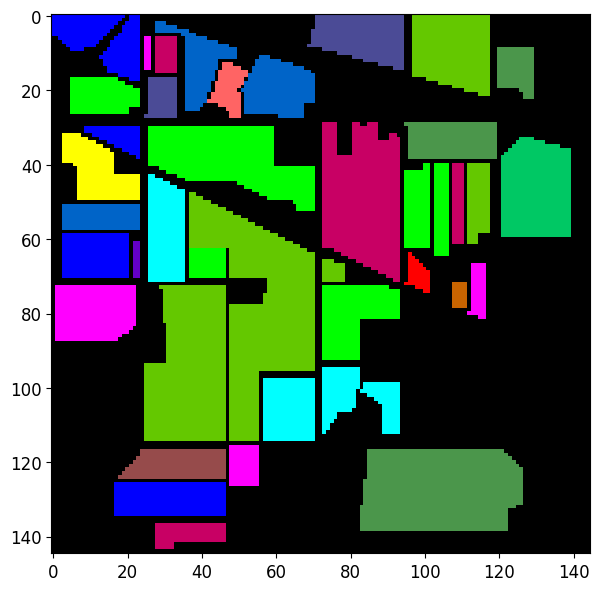

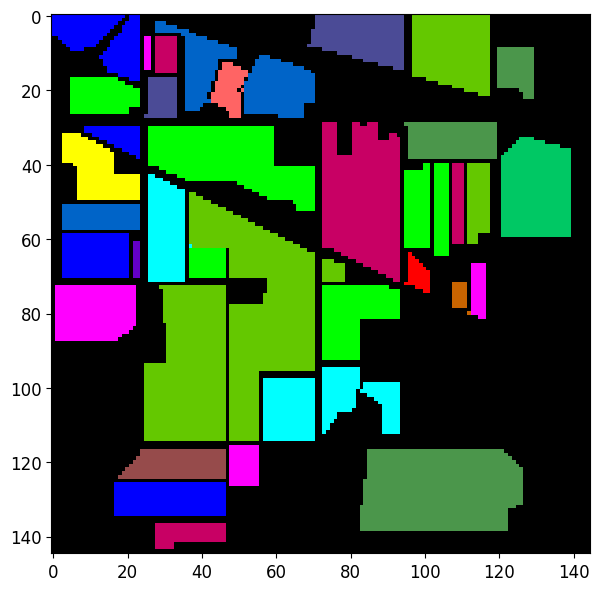

In [45]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/Save_Files/IP/IP_predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/Save_Files/IP/IP_ground_truth.png", y, colors=spectral.spy_colors)